Bibliotekos

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.5 MB/s eta 0:00:00


In [ ]:
import os
import optuna
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import zipfile
import urllib.request

In [ ]:
# Įkeliami duomenys iš github repozitorijos
os.makedirs("cnnData", exist_ok=True)
url = "https://github.com/dicodingacademy/assets/releases/download/release-rps/rps.zip"
urllib.request.urlretrieve(url, "rps.zip")

#failų išpakavimas
with zipfile.ZipFile("rps.zip", "r") as zip_ref:
    zip_ref.extractall("cnnData")

print("Duomenys išpakuoti")

Duomenys išpakuoti


Duomenų įkėlimas

In [ ]:
# nustatoma seed, kad rezultatai būtų atkartojami
myseed = 42
random.seed(myseed)
np.random.seed(myseed)
torch.manual_seed(myseed)
torch.cuda.manual_seed_all(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# pasirenkami kompiuteriniai resursai kuriuos naudosime
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


data_dir = "cnnData/rps"
categories = ["rock", "paper", "scissors"]
valid_ext = (".jpg", ".jpeg", ".png")

# vaizdų transformacijos: duomenų dydis sumažinamas ir suvienodinami matmenys iki 128x128
transform = transforms.Compose([
    transforms.Pad(padding = (0, 0, 100, 0), fill = 0),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

label_map = {"rock": 0, "paper": 1, "scissors": 2}
file_paths, labels = [], []
for category in categories:
    folder = os.path.join(data_dir, category)
    for img_name in os.listdir(folder):
        if img_name.lower().endswith(valid_ext):
            file_paths.append(os.path.join(folder, img_name))
            labels.append(label_map[category])

# duomenys suskirstomi į mokymosi, validaivmo ir testavimo aibes
X_train_val, X_test, y_train_val, y_test = train_test_split(file_paths, labels, test_size=0.1, random_state=myseed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=myseed)

Using device: cuda


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.labels[idx], dtype=torch.long)

g = torch.Generator()
g.manual_seed(myseed)

# naudojama apibrezta nuotraukų transformacija
train_set = ImageDataset(X_train, y_train, transform=transform)
val_set   = ImageDataset(X_val, y_val, transform=transform)
test_set  = ImageDataset(X_test, y_test, transform=transform)

# visi duomenys u=loadinami, kad lengviau galima juos butu pateikinėti tinklui paketais
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, generator=g)
val_loader   = DataLoader(val_set, batch_size=32)
test_loader  = DataLoader(test_set, batch_size=32)

Hiperparametrai

In [ ]:
architectures = ['Seklus', 'Vidutinis', 'Giliausias'] # skirtingos architektūros
activation_functions = ['relu', 'leakyrelu', 'sigmoid'] # aktyvacijos funkcijos
optimizer_name = ['adam', 'sgd', 'RMSprop'] # optimizavimo algorimtai
drop_outs = [0.3, 0.5] # išmetimo tikimybės
drop_out_layers = [1, 2] # išmetimo sluoksnių kiekis
learning_rate = 0.001 # mokymosi greitis
batchNorms = [True, False] # paketų normalizavimas
n_epochs = 5 # epochų skaičius
e_min = 0.0001 # minimali paklaida

CNN klasė

In [ ]:
class Classifier(nn.Module):
    def __init__(self, architecture = 'Seklus', activation = 'relu', drop_out = 0.5, drop_out_layers = 1, batchNorm = True):
        super(Classifier, self).__init__()

        # aktyvacijos funkcijų pasirinkimas
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'leakyrelu':
            self.act = nn.LeakyReLU()
        else:
            self.act = nn.Sigmoid()

        # architektūrų funkcija
        def architecture_block(in_, out_, pool = True):
            layers = [nn.Conv2d(in_, out_, kernel_size = 3, padding=1)]
            if batchNorm:
                layers.append(nn.BatchNorm2d(out_))
            layers.append(self.act)
            if pool:
                layers.append(nn.MaxPool2d(2,2))
            return layers

        # architektūrų pasirinkimas
        if architecture == 'Seklus':
            conv_layers = architecture_block(3, 32) + architecture_block(32, 64)
            fc_input = 64*32*32
        elif architecture == 'Vidutinis':
            conv_layers = architecture_block(3, 32) + architecture_block(32,64) + architecture_block(64, 128)
            fc_input = 128*16*16
        else:
            conv_layers = (
                architecture_block(3, 32)
                + architecture_block(32, 64)
                + architecture_block(64, 128)
                + architecture_block(128, 256)
            )
            fc_input = 256*8*8

        self.cnn = nn.Sequential(*conv_layers)
        fc_layers = [nn.Flatten(), nn.Linear(fc_input, 512), self.act]
        for _ in range(drop_out_layers):
            fc_layers.append(nn.Dropout(drop_out))
            fc_layers.append(nn.Linear(512, 512))
            fc_layers.append(self.act)
        fc_layers.append(nn.Linear(512, 3))

        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        return self.fc(self.cnn(x))

Optimizavimo funkcija

In [ ]:
# gauti optimizavimo algoritmus
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr = learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    else:
        return torch.optim.RMSprop(model.parameters(), lr = learning_rate)

Apmokymo funkcija ir testavimas

In [ ]:
def train_and_validate(epochs, e_min, architecture = 'Seklus', activation = 'relu', drop_out = 0.5, drop_out_layers = 1, batchNorm = True, opt_name = 'Adam', learning_rate = learning_rate):
    model = Classifier(architecture=architecture, activation=activation, drop_out=drop_out, drop_out_layers=drop_out_layers, batchNorm=batchNorm).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_choice = get_optimizer(opt_name, model, learning_rate)

    train_loss = np.inf
    epoch = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    while(train_loss > e_min and epoch < epochs):
            model.train()
            train_loss, train_acc = 0, 0

            # apmokymas su mokymosi duomenimis
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer_choice.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer_choice.step()

                train_loss += loss.item()
                train_acc += (outputs.argmax(1) == labels).float().mean().item()

            train_loss /= len(train_loader)
            train_acc /= len(train_loader)

            model.eval()
            val_loss, val_acc = 0, 0
            with torch.no_grad():
               #apmokymas su validaivmo duomenimis
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    val_acc += (outputs.argmax(1) == labels).float().mean().item()

            val_loss /= len(val_loader)
            val_acc /= len(val_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)


            print(f"Epoch {epoch+1}: TrainAcc={train_acc:.3f}, ValAcc={val_acc:.3f}")
            epoch += 1

    model.eval()
    test_loss, test_acc = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
      #testavimas
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).float().mean().item()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}\n")

    return model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, np.array(all_labels), np.array(all_preds)

Grafikų piešimo funkcija

In [ ]:
def plot_comparison(df, x_col, y1, y2, title, xlabel, ylabel, figsize=(7,4), ylim=None):
    x = np.arange(len(df[x_col]))
    width = 0.35
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x - width/2, df[y1], width, label='Mokymosi', color='blue')
    ax.bar(x + width/2, df[y2], width, label='Validavimo', color='pink')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df[x_col], rotation=0)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.legend()
    ax.grid(axis='y', alpha=0.7)
    plt.show()

Skirtingos architektūros

Mokymas su architektūra: Seklus
Epoch 1: TrainAcc=0.386, ValAcc=0.504
Epoch 2: TrainAcc=0.461, ValAcc=0.547
Epoch 3: TrainAcc=0.517, ValAcc=0.342
Epoch 4: TrainAcc=0.512, ValAcc=0.647
Epoch 5: TrainAcc=0.521, ValAcc=0.721
Test Accuracy: 0.698, Test Loss: 0.764

Mokymas su architektūra: Vidutinis
Epoch 1: TrainAcc=0.399, ValAcc=0.448
Epoch 2: TrainAcc=0.503, ValAcc=0.542
Epoch 3: TrainAcc=0.720, ValAcc=0.969
Epoch 4: TrainAcc=0.838, ValAcc=0.988
Epoch 5: TrainAcc=0.944, ValAcc=0.988
Test Accuracy: 0.980, Test Loss: 0.068

Mokymas su architektūra: Giliausias
Epoch 1: TrainAcc=0.379, ValAcc=0.354
Epoch 2: TrainAcc=0.498, ValAcc=0.604
Epoch 3: TrainAcc=0.673, ValAcc=0.897
Epoch 4: TrainAcc=0.901, ValAcc=0.992
Epoch 5: TrainAcc=0.973, ValAcc=0.996
Test Accuracy: 0.988, Test Loss: 0.031

  Architektūra  Train Loss  Train Accuracy  Validation Loss  \
0       Seklus    0.930445        0.520833         0.753840   
1    Vidutinis    0.159998        0.943948         0.053190   
2   Giliausias    

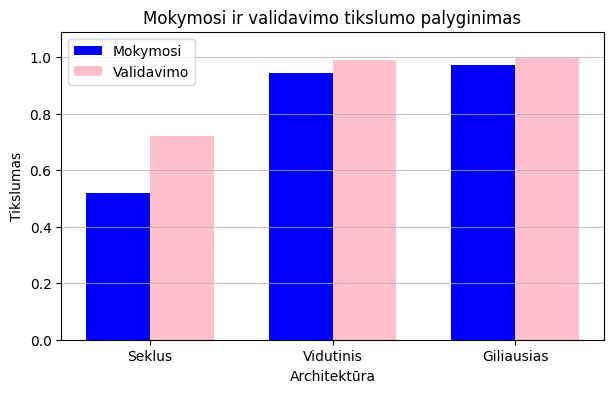

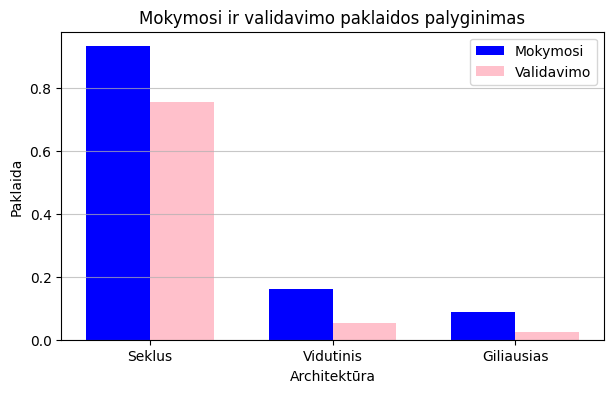

In [ ]:
results = {}

for architecture in architectures:
    print(f"Mokymas su architektūra: {architecture}")
    model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred = train_and_validate(
        epochs=n_epochs, e_min=e_min, architecture=architecture,
        activation='relu', drop_out=0.5, drop_out_layers=1,
        batchNorm=True, opt_name='Adam', learning_rate=0.001)
    results[architecture] = {
    'train_acc': train_accs[-1],
    'train_loss': train_losses[-1],
    'val_acc': val_accs[-1],
    'val_loss': val_losses[-1],
    'test_acc': test_acc,
    'test_loss': test_loss
}

df_results = pd.DataFrame({
    'Architektūra': list(results.keys()),
    'Train Loss': [r['train_loss'] for r in results.values()],
    'Train Accuracy': [r['train_acc'] for r in results.values()],
    'Validation Loss': [r['val_loss'] for r in results.values()],
    'Validation Accuracy': [r['val_acc'] for r in results.values()],
    'Test Accuracy': [r['test_acc'] for r in results.values()],
    'Test Loss': [r['test_loss'] for r in results.values()]
})

print(df_results)
plot_comparison(df_results, 'Architektūra', 'Train Accuracy', 'Validation Accuracy', 'Mokymosi ir validavimo tikslumo palyginimas', 'Architektūra', 'Tikslumas', ylim=(0,1.09))
plot_comparison(df_results, 'Architektūra', 'Train Loss', 'Validation Loss', 'Mokymosi ir validavimo paklaidos palyginimas', 'Architektūra', 'Paklaida')

Skirtingi išmetimų sluoksnių kiekiais ir išmetimo tikimybių reikšmėmis

Mokymas 1 išmetimo sluoksniais ir 0.3 išmetimo tikimybe
Epoch 1: TrainAcc=0.377, ValAcc=0.455
Epoch 2: TrainAcc=0.474, ValAcc=0.547
Epoch 3: TrainAcc=0.575, ValAcc=0.633
Epoch 4: TrainAcc=0.600, ValAcc=0.607
Epoch 5: TrainAcc=0.734, ValAcc=0.984
Test Accuracy: 0.980, Test Loss: 0.332

Mokymas 1 išmetimo sluoksniais ir 0.5 išmetimo tikimybe
Epoch 1: TrainAcc=0.409, ValAcc=0.448
Epoch 2: TrainAcc=0.464, ValAcc=0.617
Epoch 3: TrainAcc=0.494, ValAcc=0.829
Epoch 4: TrainAcc=0.525, ValAcc=0.932
Epoch 5: TrainAcc=0.605, ValAcc=0.892
Test Accuracy: 0.889, Test Loss: 0.585

Mokymas 2 išmetimo sluoksniais ir 0.3 išmetimo tikimybe
Epoch 1: TrainAcc=0.374, ValAcc=0.425
Epoch 2: TrainAcc=0.517, ValAcc=0.657
Epoch 3: TrainAcc=0.575, ValAcc=0.656
Epoch 4: TrainAcc=0.662, ValAcc=0.944
Epoch 5: TrainAcc=0.816, ValAcc=0.992
Test Accuracy: 0.992, Test Loss: 0.111

Mokymas 2 išmetimo sluoksniais ir 0.5 išmetimo tikimybe
Epoch 1: TrainAcc=0.352, ValAcc=0.491
Epoch 2: TrainAcc=0.446, ValAcc=0.456
Epoch 3: T

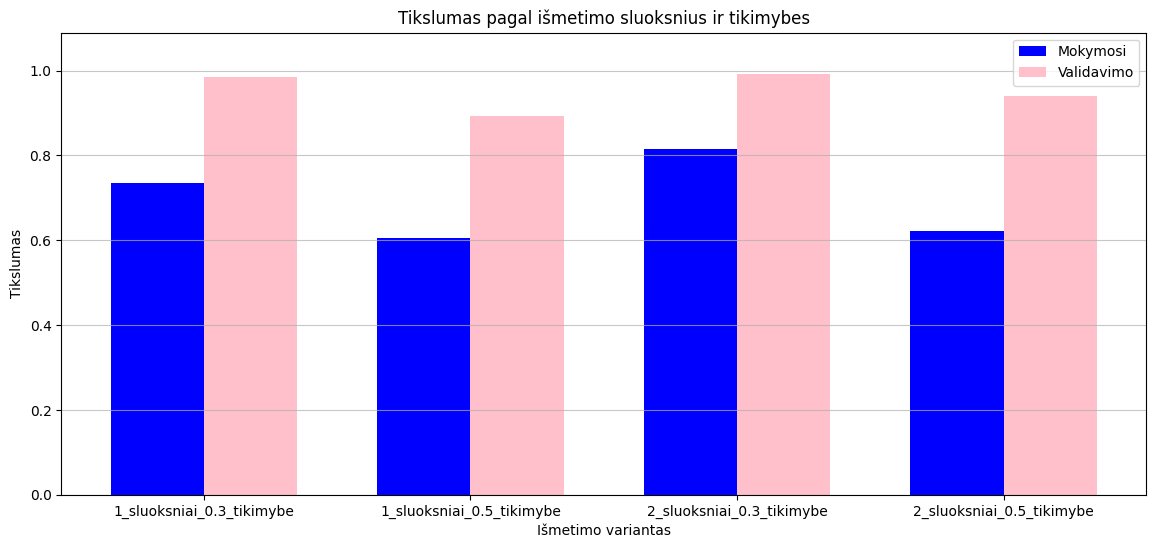

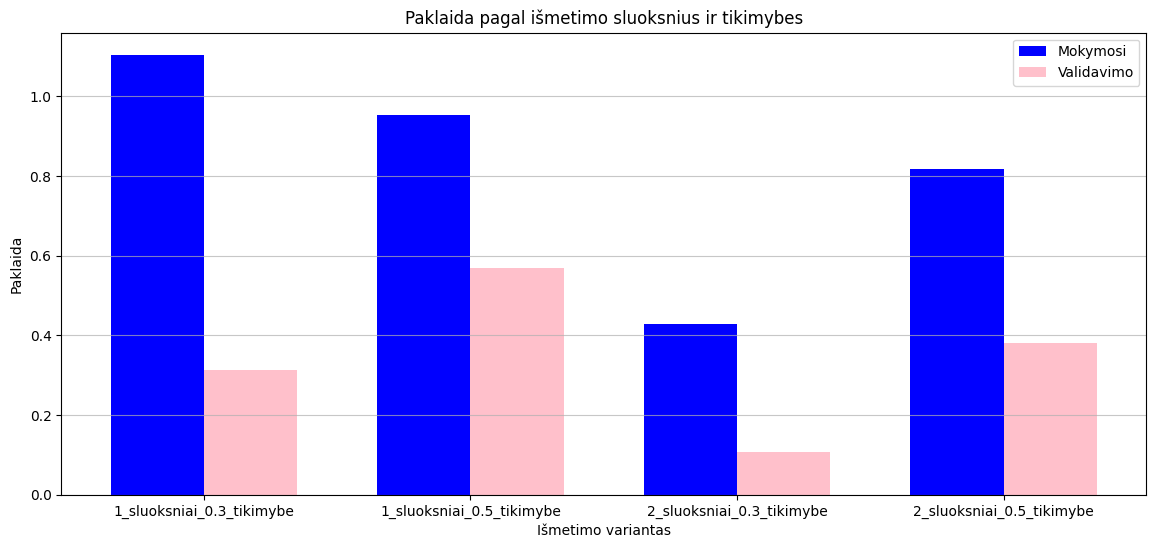

In [ ]:
results_drop_out = {}

for drop_out_layer in drop_out_layers:
  for drop_out in drop_outs:
      print(f"Mokymas {drop_out_layer} išmetimo sluoksniais ir {drop_out} išmetimo tikimybe")
      model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred = train_and_validate(
          epochs=n_epochs, e_min=e_min, architecture='Seklus', activation='relu',
          drop_out=drop_out, drop_out_layers=drop_out_layer, batchNorm=True,
          opt_name='Adam', learning_rate=0.001)

      key = f"{drop_out_layer}_sluoksniai_{drop_out}_tikimybe"
      results_drop_out[key] = {
            'train_acc': train_accs[-1],
            'train_loss': train_losses[-1],
            'val_acc': val_accs[-1],
            'val_loss': val_losses[-1],
            'test_acc': test_acc,
            'test_loss': test_loss
        }

df_results_drop = pd.DataFrame({
    'Dropout variantas': list(results_drop_out.keys()),
    'Train Loss': [r['train_loss'] for r in results_drop_out.values()],
    'Train Accuracy': [r['train_acc'] for r in results_drop_out.values()],
    'Validation Loss': [r['val_loss'] for r in results_drop_out.values()],
    'Validation Accuracy': [r['val_acc'] for r in results_drop_out.values()],
    'Test Accuracy': [r['test_acc'] for r in results_drop_out.values()],
    'Test Loss': [r['test_loss'] for r in results_drop_out.values()]
})

print(df_results_drop)

plot_comparison(df_results_drop, 'Dropout variantas', 'Train Accuracy', 'Validation Accuracy', 'Tikslumas pagal išmetimo sluoksnius ir tikimybes', 'Išmetimo variantas', 'Tikslumas', figsize=(14,6), ylim=(0,1.09))
plot_comparison(df_results_drop, 'Dropout variantas', 'Train Loss', 'Validation Loss', 'Paklaida pagal išmetimo sluoksnius ir tikimybes', 'Išmetimo variantas', 'Paklaida', figsize=(14,6))

Apmokymas su skirtingom aktyvacijos funkcijom

Mokymas su aktyvacijos funkcija: relu
Epoch 1: TrainAcc=0.440, ValAcc=0.662
Epoch 2: TrainAcc=0.568, ValAcc=0.440
Epoch 3: TrainAcc=0.554, ValAcc=0.797
Epoch 4: TrainAcc=0.500, ValAcc=0.453
Epoch 5: TrainAcc=0.609, ValAcc=0.794
Test Accuracy: 0.789, Test Loss: 0.565

Mokymas su aktyvacijos funkcija: leakyrelu
Epoch 1: TrainAcc=0.418, ValAcc=0.386
Epoch 2: TrainAcc=0.525, ValAcc=0.630
Epoch 3: TrainAcc=0.627, ValAcc=0.781
Epoch 4: TrainAcc=0.708, ValAcc=0.497
Epoch 5: TrainAcc=0.715, ValAcc=0.791
Test Accuracy: 0.723, Test Loss: 0.605

Mokymas su aktyvacijos funkcija: sigmoid
Epoch 1: TrainAcc=0.336, ValAcc=0.334
Epoch 2: TrainAcc=0.324, ValAcc=0.332
Epoch 3: TrainAcc=0.335, ValAcc=0.332
Epoch 4: TrainAcc=0.341, ValAcc=0.334
Epoch 5: TrainAcc=0.328, ValAcc=0.334
Test Accuracy: 0.342, Test Loss: 1.099

  Aktyvacijos funkcija  Train Loss  Train Accuracy  Validation Loss  \
0                 relu    0.970740        0.608631         0.556400   
1            leakyrelu    0.729882        0.71

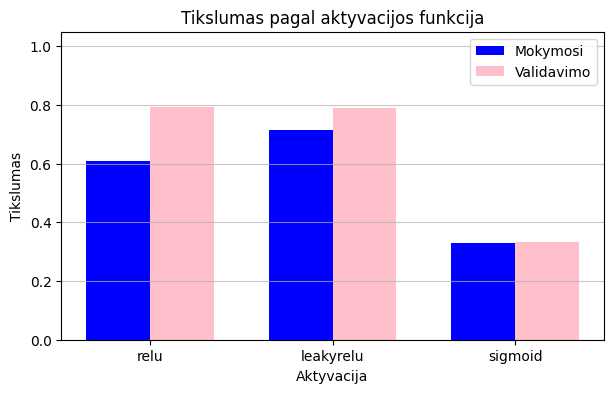

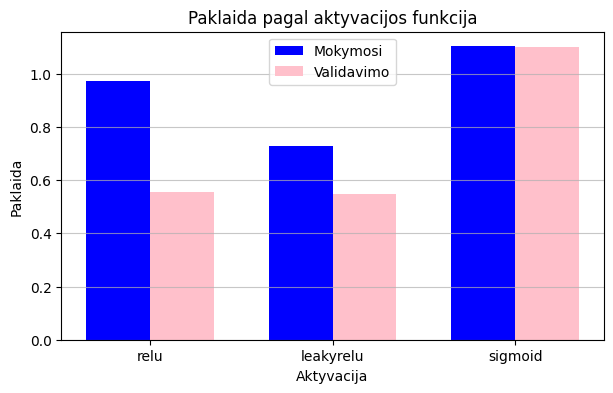

In [ ]:
results_activation = {}

for activation_function in activation_functions:
    print(f"Mokymas su aktyvacijos funkcija: {activation_function}")
    model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred= train_and_validate(
        epochs=n_epochs,
        e_min=e_min,
        architecture='Seklus',
        activation=activation_function,
        drop_out=0.5,
        drop_out_layers=1,
        batchNorm=True,
        opt_name='Adam',
        learning_rate=0.001
    )

    results_activation[activation_function] = {
        'train_acc': train_accs[-1],
        'train_loss': train_losses[-1],
        'val_acc': val_accs[-1],
        'val_loss': val_losses[-1],
        'test_acc': test_acc,
        'test_loss': test_loss
    }

df_activations = pd.DataFrame({
    'Aktyvacijos funkcija': list(results_activation.keys()),
    'Train Loss': [r['train_loss'] for r in results_activation.values()],
    'Train Accuracy': [r['train_acc'] for r in results_activation.values()],
    'Validation Loss': [r['val_loss'] for r in results_activation.values()],
    'Validation Accuracy': [r['val_acc'] for r in results_activation.values()],
    'Test Accuracy': [r['test_acc'] for r in results_activation.values()],
    'Test Loss': [r['test_loss'] for r in results_activation.values()]
})

print(df_activations)
plot_comparison(df_activations, 'Aktyvacijos funkcija', 'Train Accuracy', 'Validation Accuracy', 'Tikslumas pagal aktyvacijos funkcija', 'Aktyvacija', 'Tikslumas', ylim=(0,1.05))
plot_comparison(df_activations, 'Aktyvacijos funkcija', 'Train Loss', 'Validation Loss', 'Paklaida pagal aktyvacijos funkcija', 'Aktyvacija', 'Paklaida')

Apmokymas su paketų normalizavimu ir be

Mokymas kai normalizavimas: True
Epoch 1: TrainAcc=0.427, ValAcc=0.663
Epoch 2: TrainAcc=0.600, ValAcc=0.853
Epoch 3: TrainAcc=0.686, ValAcc=0.988
Epoch 4: TrainAcc=0.749, ValAcc=0.849
Epoch 5: TrainAcc=0.881, ValAcc=0.984
Test Accuracy: 0.980, Test Loss: 0.114

Mokymas kai normalizavimas: False
Epoch 1: TrainAcc=0.337, ValAcc=0.334
Epoch 2: TrainAcc=0.335, ValAcc=0.334
Epoch 3: TrainAcc=0.330, ValAcc=0.501
Epoch 4: TrainAcc=0.345, ValAcc=0.354
Epoch 5: TrainAcc=0.344, ValAcc=0.357
Test Accuracy: 0.435, Test Loss: 1.091

   Normalizavimas  Train Loss  Train Accuracy  Validation Loss  \
0            True    0.295872        0.881448         0.103316   
1           False    1.098589        0.343750         1.095038   

   Validation Accuracy  Test Accuracy  Test Loss  
0             0.984375       0.979911   0.114404  
1             0.357143       0.434710   1.090805  


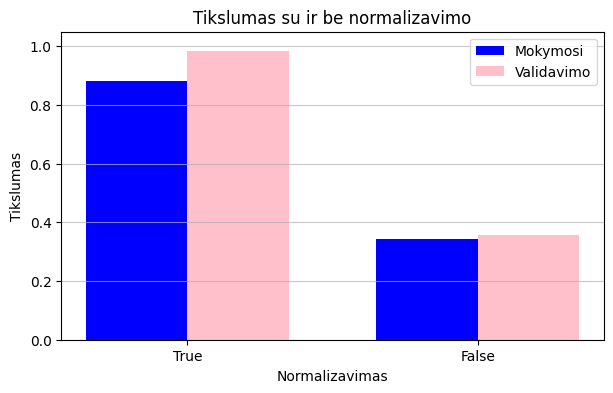

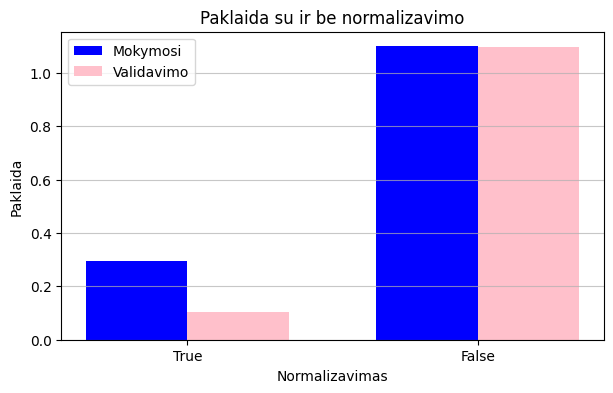

In [ ]:
results_norm = {}

for norm in batchNorms:
    print(f"Mokymas kai normalizavimas: {norm}")
    model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred = train_and_validate(
        epochs=n_epochs, e_min=e_min, architecture='Seklus',
        activation='relu', drop_out=0.5, drop_out_layers=1,
        batchNorm=norm, opt_name='Adam', learning_rate=0.001)

    results_norm[norm] = {
    'train_acc': train_accs[-1],
    'train_loss': train_losses[-1],
    'val_acc': val_accs[-1],
    'val_loss': val_losses[-1],
    'test_acc': test_acc,
    'test_loss': test_loss
}

df_results = pd.DataFrame({
    'Normalizavimas': list(results_norm.keys()),
    'Train Loss': [r['train_loss'] for r in results_norm.values()],
    'Train Accuracy': [r['train_acc'] for r in results_norm.values()],
    'Validation Loss': [r['val_loss'] for r in results_norm.values()],
    'Validation Accuracy': [r['val_acc'] for r in results_norm.values()],
    'Test Accuracy': [r['test_acc'] for r in results_norm.values()],
    'Test Loss': [r['test_loss'] for r in results_norm.values()]
})

print(df_results)

plot_comparison(df_results, 'Normalizavimas', 'Train Accuracy', 'Validation Accuracy', 'Tikslumas su ir be normalizavimo', 'Normalizavimas', 'Tikslumas', ylim=(0,1.05))
plot_comparison(df_results, 'Normalizavimas', 'Train Loss', 'Validation Loss', 'Paklaida su ir be normalizavimo', 'Normalizavimas', 'Paklaida')

Apmokymas su skirtingais optimizavimo algoritmais

Mokymas su optimizavimu : adam
Epoch 1: TrainAcc=0.605, ValAcc=0.984
Epoch 2: TrainAcc=0.946, ValAcc=0.992
Epoch 3: TrainAcc=0.976, ValAcc=0.992
Epoch 4: TrainAcc=0.985, ValAcc=0.992
Epoch 5: TrainAcc=0.985, ValAcc=0.996
Test Accuracy: 0.996, Test Loss: 0.009

Mokymas su optimizavimu : sgd
Epoch 1: TrainAcc=0.664, ValAcc=0.984
Epoch 2: TrainAcc=0.962, ValAcc=0.988
Epoch 3: TrainAcc=0.987, ValAcc=0.992
Epoch 4: TrainAcc=0.998, ValAcc=0.996
Epoch 5: TrainAcc=1.000, ValAcc=0.992
Test Accuracy: 0.992, Test Loss: 0.021

Mokymas su optimizavimu : RMSprop
Epoch 1: TrainAcc=0.410, ValAcc=0.375
Epoch 2: TrainAcc=0.588, ValAcc=0.894
Epoch 3: TrainAcc=0.685, ValAcc=0.933
Epoch 4: TrainAcc=0.802, ValAcc=0.881
Epoch 5: TrainAcc=0.911, ValAcc=0.992
Test Accuracy: 1.000, Test Loss: 0.062

  Optimizavimas  Train Loss  Train Accuracy  Validation Loss  \
0          adam    0.035079        0.985119         0.011681   
1           sgd    0.009593        0.999504         0.017489   
2       RMSprop    0.27

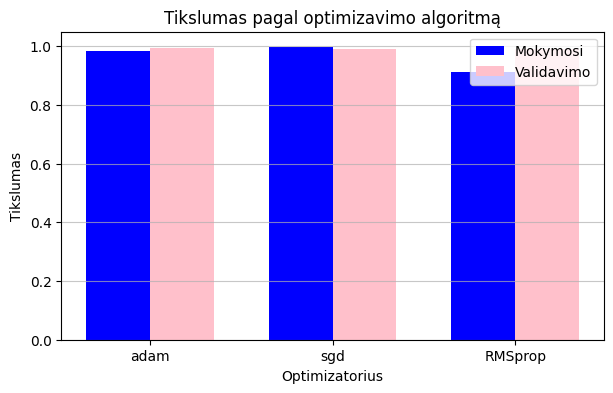

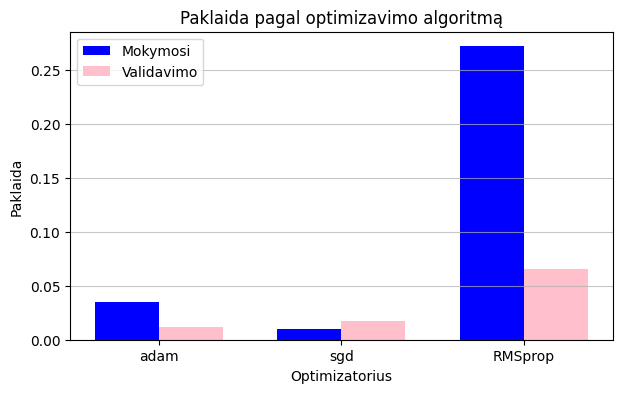

In [ ]:
results_opt = {}

for opt in optimizer_name:
    print(f"Mokymas su optimizavimu : {opt}")
    model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred = train_and_validate(
        epochs=n_epochs,
        e_min=e_min,
        architecture='Seklus',
        activation='relu',
        drop_out=0.5,
        drop_out_layers=1,
        batchNorm=True,
        opt_name=opt,
        learning_rate=0.001
    )
    results_opt[opt] = {
    'train_acc': train_accs[-1],
    'train_loss': train_losses[-1],
    'val_acc': val_accs[-1],
    'val_loss': val_losses[-1],
    'test_acc': test_acc,
    'test_loss': test_loss
}

df_results = pd.DataFrame({
    'Optimizavimas': list(results_opt.keys()),
    'Train Loss': [r['train_loss'] for r in results_opt.values()],
    'Train Accuracy': [r['train_acc'] for r in results_opt.values()],
    'Validation Loss': [r['val_loss'] for r in results_opt.values()],
    'Validation Accuracy': [r['val_acc'] for r in results_opt.values()],
    'Test Accuracy': [r['test_acc'] for r in results_opt.values()],
    'Test Loss': [r['test_loss'] for r in results_opt.values()]
})

print(df_results)

plot_comparison(df_results, 'Optimizavimas', 'Train Accuracy', 'Validation Accuracy', 'Tikslumas pagal optimizavimo algoritmą', 'Optimizatorius', 'Tikslumas', ylim=(0,1.05))
plot_comparison(df_results, 'Optimizavimas', 'Train Loss', 'Validation Loss', 'Paklaida pagal optimizavimo algoritmą', 'Optimizatorius', 'Paklaida')

Geriausio modelio radimas su Bajeso optimizacija

In [ ]:
def objective(trial):
    architecture = trial.suggest_categorical("architecture", architectures)
    activation = trial.suggest_categorical("activation", activation_functions)
    drop_out = trial.suggest_categorical("drop_out", [0.3, 0.5])
    drop_out_layer = trial.suggest_int("drop_out_layer", 1, 2)
    batchNorm = trial.suggest_categorical("batchNorm", [True, False])
    opt_name = trial.suggest_categorical("opt_name", optimizer_name)

    model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred = train_and_validate(
        epochs=3, e_min=e_min,
        architecture=architecture,
        activation=activation,
        drop_out=drop_out,
        drop_out_layers=drop_out_layer,
        batchNorm=batchNorm,
        opt_name=opt_name,
        learning_rate=learning_rate
    )

    return val_accs[-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Geriausi parametrai:", study.best_params)

[I 2025-10-28 09:48:46,120] A new study created in memory with name: no-name-2486ad6d-0542-45e0-b7a8-769b1e29078e


Epoch 1: TrainAcc=0.399, ValAcc=0.779
Epoch 2: TrainAcc=0.730, ValAcc=0.830
Epoch 3: TrainAcc=0.858, ValAcc=0.462


[I 2025-10-28 09:49:19,814] Trial 0 finished with value: 0.4620535746216774 and parameters: {'architecture': 'Seklus', 'activation': 'relu', 'drop_out': 0.5, 'drop_out_layer': 2, 'batchNorm': True, 'opt_name': 'adam'}. Best is trial 0 with value: 0.4620535746216774.


Test Accuracy: 0.487, Test Loss: 3.904

Epoch 1: TrainAcc=0.338, ValAcc=0.332
Epoch 2: TrainAcc=0.341, ValAcc=0.332
Epoch 3: TrainAcc=0.333, ValAcc=0.334


[I 2025-10-28 09:49:52,500] Trial 1 finished with value: 0.3342633955180645 and parameters: {'architecture': 'Vidutinis', 'activation': 'sigmoid', 'drop_out': 0.5, 'drop_out_layer': 1, 'batchNorm': True, 'opt_name': 'sgd'}. Best is trial 0 with value: 0.4620535746216774.


Test Accuracy: 0.342, Test Loss: 1.095

Epoch 1: TrainAcc=0.354, ValAcc=0.334
Epoch 2: TrainAcc=0.336, ValAcc=0.334
Epoch 3: TrainAcc=0.347, ValAcc=0.334


[I 2025-10-28 09:50:25,262] Trial 2 finished with value: 0.3342633955180645 and parameters: {'architecture': 'Vidutinis', 'activation': 'sigmoid', 'drop_out': 0.3, 'drop_out_layer': 2, 'batchNorm': True, 'opt_name': 'RMSprop'}. Best is trial 0 with value: 0.4620535746216774.


Test Accuracy: 0.342, Test Loss: 1.116

Epoch 1: TrainAcc=0.667, ValAcc=0.719
Epoch 2: TrainAcc=0.958, ValAcc=0.996
Epoch 3: TrainAcc=0.991, ValAcc=0.992


[I 2025-10-28 09:50:58,565] Trial 3 finished with value: 0.9921875 and parameters: {'architecture': 'Vidutinis', 'activation': 'leakyrelu', 'drop_out': 0.5, 'drop_out_layer': 1, 'batchNorm': True, 'opt_name': 'adam'}. Best is trial 3 with value: 0.9921875.


Test Accuracy: 0.984, Test Loss: 0.020

Epoch 1: TrainAcc=0.341, ValAcc=0.334
Epoch 2: TrainAcc=0.328, ValAcc=0.332
Epoch 3: TrainAcc=0.309, ValAcc=0.334


[I 2025-10-28 09:51:30,068] Trial 4 finished with value: 0.3337053582072258 and parameters: {'architecture': 'Seklus', 'activation': 'sigmoid', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'sgd'}. Best is trial 3 with value: 0.9921875.


Test Accuracy: 0.331, Test Loss: 1.103

Epoch 1: TrainAcc=0.479, ValAcc=0.905
Epoch 2: TrainAcc=0.968, ValAcc=0.996
Epoch 3: TrainAcc=0.997, ValAcc=1.000


[I 2025-10-28 09:52:01,931] Trial 5 finished with value: 1.0 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 1.000, Test Loss: 0.002

Epoch 1: TrainAcc=0.362, ValAcc=0.336
Epoch 2: TrainAcc=0.459, ValAcc=0.523
Epoch 3: TrainAcc=0.547, ValAcc=0.708


[I 2025-10-28 09:52:34,278] Trial 6 finished with value: 0.707589291036129 and parameters: {'architecture': 'Vidutinis', 'activation': 'leakyrelu', 'drop_out': 0.5, 'drop_out_layer': 1, 'batchNorm': True, 'opt_name': 'RMSprop'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.703, Test Loss: 0.732

Epoch 1: TrainAcc=0.327, ValAcc=0.334
Epoch 2: TrainAcc=0.312, ValAcc=0.334
Epoch 3: TrainAcc=0.320, ValAcc=0.334


[I 2025-10-28 09:53:06,043] Trial 7 finished with value: 0.3342633955180645 and parameters: {'architecture': 'Vidutinis', 'activation': 'sigmoid', 'drop_out': 0.3, 'drop_out_layer': 2, 'batchNorm': False, 'opt_name': 'RMSprop'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.342, Test Loss: 1.105

Epoch 1: TrainAcc=0.334, ValAcc=0.334
Epoch 2: TrainAcc=0.333, ValAcc=0.334
Epoch 3: TrainAcc=0.362, ValAcc=0.334


[I 2025-10-28 09:53:37,056] Trial 8 finished with value: 0.3342633955180645 and parameters: {'architecture': 'Vidutinis', 'activation': 'leakyrelu', 'drop_out': 0.3, 'drop_out_layer': 2, 'batchNorm': False, 'opt_name': 'sgd'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.342, Test Loss: 1.098

Epoch 1: TrainAcc=0.326, ValAcc=0.334
Epoch 2: TrainAcc=0.327, ValAcc=0.334
Epoch 3: TrainAcc=0.327, ValAcc=0.334


[I 2025-10-28 09:54:09,523] Trial 9 finished with value: 0.3342633955180645 and parameters: {'architecture': 'Seklus', 'activation': 'sigmoid', 'drop_out': 0.5, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.342, Test Loss: 1.109

Epoch 1: TrainAcc=0.496, ValAcc=0.833
Epoch 2: TrainAcc=0.975, ValAcc=0.992
Epoch 3: TrainAcc=0.995, ValAcc=1.000


[I 2025-10-28 09:54:41,656] Trial 10 finished with value: 1.0 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 1.000, Test Loss: 0.016

Epoch 1: TrainAcc=0.369, ValAcc=0.592
Epoch 2: TrainAcc=0.867, ValAcc=0.920
Epoch 3: TrainAcc=0.982, ValAcc=0.972


[I 2025-10-28 09:55:13,969] Trial 11 finished with value: 0.9720982164144516 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.988, Test Loss: 0.035

Epoch 1: TrainAcc=0.594, ValAcc=0.944
Epoch 2: TrainAcc=0.984, ValAcc=0.996
Epoch 3: TrainAcc=0.998, ValAcc=1.000


[I 2025-10-28 09:55:46,683] Trial 12 finished with value: 1.0 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 1.000, Test Loss: 0.002

Epoch 1: TrainAcc=0.422, ValAcc=0.727
Epoch 2: TrainAcc=0.921, ValAcc=0.996
Epoch 3: TrainAcc=0.995, ValAcc=1.000


[I 2025-10-28 09:56:18,803] Trial 13 finished with value: 1.0 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 1.000, Test Loss: 0.005

Epoch 1: TrainAcc=0.542, ValAcc=0.902
Epoch 2: TrainAcc=0.969, ValAcc=0.996
Epoch 3: TrainAcc=0.997, ValAcc=0.984


[I 2025-10-28 09:56:50,405] Trial 14 finished with value: 0.984375 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.996, Test Loss: 0.011

Epoch 1: TrainAcc=0.499, ValAcc=0.814
Epoch 2: TrainAcc=0.939, ValAcc=0.996
Epoch 3: TrainAcc=0.989, ValAcc=1.000


[I 2025-10-28 09:57:22,508] Trial 15 finished with value: 1.0 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.996, Test Loss: 0.004

Epoch 1: TrainAcc=0.479, ValAcc=0.826
Epoch 2: TrainAcc=0.952, ValAcc=0.996
Epoch 3: TrainAcc=0.999, ValAcc=1.000


[I 2025-10-28 09:57:54,639] Trial 16 finished with value: 1.0 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 1.000, Test Loss: 0.001

Epoch 1: TrainAcc=0.317, ValAcc=0.334
Epoch 2: TrainAcc=0.603, ValAcc=0.940
Epoch 3: TrainAcc=0.966, ValAcc=0.996


[I 2025-10-28 09:58:26,170] Trial 17 finished with value: 0.99609375 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 2, 'batchNorm': False, 'opt_name': 'adam'}. Best is trial 5 with value: 1.0.


Test Accuracy: 1.000, Test Loss: 0.007

Epoch 1: TrainAcc=0.388, ValAcc=0.334
Epoch 2: TrainAcc=0.673, ValAcc=0.780
Epoch 3: TrainAcc=0.809, ValAcc=0.953


[I 2025-10-28 09:58:58,388] Trial 18 finished with value: 0.953125 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'RMSprop'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.955, Test Loss: 0.142

Epoch 1: TrainAcc=0.332, ValAcc=0.334
Epoch 2: TrainAcc=0.324, ValAcc=0.334
Epoch 3: TrainAcc=0.332, ValAcc=0.334


[I 2025-10-28 09:59:30,330] Trial 19 finished with value: 0.3342633955180645 and parameters: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'sgd'}. Best is trial 5 with value: 1.0.


Test Accuracy: 0.342, Test Loss: 1.098

Geriausi parametrai: {'architecture': 'Giliausias', 'activation': 'relu', 'drop_out': 0.3, 'drop_out_layer': 1, 'batchNorm': False, 'opt_name': 'adam'}


Geriausio modelio treniravimas

Epoch 1: TrainAcc=0.713, ValAcc=0.988
Epoch 2: TrainAcc=0.989, ValAcc=0.996
Epoch 3: TrainAcc=1.000, ValAcc=1.000
Epoch 4: TrainAcc=0.999, ValAcc=0.996
Epoch 5: TrainAcc=0.999, ValAcc=0.996
Test Accuracy: 0.996, Test Loss: 0.011



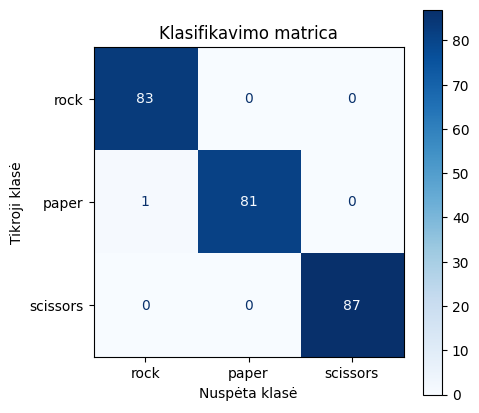

30 testinių įrašų (tikra vs. spėta):
Tikra: paper | Spėta: paper
Tikra: paper | Spėta: paper
Tikra: scissors | Spėta: scissors
Tikra: rock | Spėta: rock
Tikra: scissors | Spėta: scissors
Tikra: paper | Spėta: paper
Tikra: scissors | Spėta: scissors
Tikra: rock | Spėta: rock
Tikra: scissors | Spėta: scissors
Tikra: rock | Spėta: rock
Tikra: scissors | Spėta: scissors
Tikra: paper | Spėta: paper
Tikra: scissors | Spėta: scissors
Tikra: paper | Spėta: paper
Tikra: rock | Spėta: rock
Tikra: scissors | Spėta: scissors
Tikra: scissors | Spėta: scissors
Tikra: paper | Spėta: paper
Tikra: paper | Spėta: paper
Tikra: scissors | Spėta: scissors
Tikra: paper | Spėta: paper
Tikra: rock | Spėta: rock
Tikra: rock | Spėta: rock
Tikra: scissors | Spėta: scissors
Tikra: paper | Spėta: paper
Tikra: rock | Spėta: rock
Tikra: scissors | Spėta: scissors
Tikra: scissors | Spėta: scissors
Tikra: scissors | Spėta: scissors
Tikra: rock | Spėta: rock


In [ ]:
best = study.best_params

model, train_accs, train_losses, val_accs, val_losses, test_acc, test_loss, y_true, y_pred = train_and_validate(
    epochs=5,
    e_min=e_min,
    architecture=best['architecture'],
    activation=best['activation'],
    drop_out=best['drop_out'],
    drop_out_layers=best['drop_out_layer'],
    batchNorm=best['batchNorm'],
    opt_name=best['opt_name'],
    learning_rate=learning_rate
)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Klasifikavimo matrica')
ax.set_xlabel('Nuspėta klasė')
ax.set_ylabel('Tikroji klasė')
plt.show()

np.random.seed(myseed)
idx = np.random.choice(len(y_true), 30, replace=False)
print("30 testinių įrašų (tikra vs. spėta):")
for i in idx:
    print(f"Tikra: {categories[y_true[i]]} | Spėta: {categories[y_pred[i]]}")
